### Feature engineering

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [5]:
df["day"] = df["date_time"].dt.day
df["hour"] = df["date_time"].dt.hour
df.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,day,hour
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,10,18
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,10,19
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,10,20
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,10,21
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,10,22


In [6]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']

In [7]:
seasons = ['spring', 'summer', 'autumn', 'winter']

In [8]:
def season(date):
    x = date.month
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'autumn'

In [9]:
df['season'] = df['date_time'].apply(season)

In [10]:
months = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul',
          8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

In [11]:
def month(date):
    months = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 
              8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}
    return months[int(date.month)]

In [12]:
df['month'] = df['date_time'].apply(month)

In [13]:
columns = list(df.columns)

In [14]:
columns

['date_time',
 'deg_C',
 'relative_humidity',
 'absolute_humidity',
 'sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5',
 'target_carbon_monoxide',
 'target_benzene',
 'target_nitrogen_oxides',
 'day',
 'hour',
 'season',
 'month']

In [15]:
columns = list(df.columns)

In [16]:
def lag_feature(df, columns, lag):
    for col in columns:
        df['lag_' + str(lag) + '_' + col] = df[col].shift(lag)

In [17]:
def RWF(series, lag): # rolling window feature
    return series.rolling(lag)

In [18]:
def EWF(series, lag): # expanding window feature
    return series.expanding(lag)

In [19]:
from statsmodels.api import tsa
from statsmodels.graphics import tsaplots

In [20]:
columns = list(df.columns)
columns

['date_time',
 'deg_C',
 'relative_humidity',
 'absolute_humidity',
 'sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5',
 'target_carbon_monoxide',
 'target_benzene',
 'target_nitrogen_oxides',
 'day',
 'hour',
 'season',
 'month']

In [21]:
for col in columns[16:]:
    df[col] = df[col].apply(int)

In [22]:
seasons_dict = {'winter' : 1, 'spring' : 2, 'summer' : 3, 'autumn' : 4}

In [23]:
df['season'] = df['season'].apply(lambda x : seasons_dict[x])

In [24]:
from statsmodels.tsa import seasonal as ssn

In [25]:
def get_STL(series, period):
    stl = ssn.STL(series, period = period).fit()
    return [stl.trend, stl.seasonal,  stl.resid] 

In [26]:
df['month'] = df['date_time'].dt.month

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
def outliers_frame(series,conf_interval = True, boxplots = True, scale = 1.96, lag = 24 ,perc = [25,75]):
    
    if boxplots == True:
        Q1, Q3 = np.percentile(series, perc)
        IQR = Q3 - Q1
        [dw, uw] = [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
        outliers = np.logical_or(series <= dw , series >= uw)
    
    if conf_interval == True:
        rolling_mean = series.rolling(lag).mean()
        mae = mean_absolute_error(series[lag:], rolling_mean[lag:])
        deviation = np.std(series[lag:] - rolling_mean[lag:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        anomalies = np.logical_or(series > upper_bond , series < lower_bond)
        
    if boxplots and conf_interval:
        return [anomalies, outliers]
    elif boxplots ^ conf_interval:
        if boxplots: return outliers
        else: return anomalies
    else:
        return []

In [29]:
columns = list(df.columns)

In [30]:
f_dict = {f_name : [df[f_name]] for f_name in columns[1:]} # features series dict

In [31]:
def agr_feature(f_dict, df, column, func, features = {}):
    arg_dict = {'lag' : 0, 'RWF' : 0, 'EWF' : 0, 'STL' : 0, 'outliers' : (0,0,[0,0])}
    for key in features.keys():
        arg_dict[key] = features[key]
    if arg_dict['lag'] != 0:
        f_dict[column].append(lag_feature(df, columns, arg_dict['lag']))
        f_dict[column][-1].name = 'lag_' + str(arg_dict['lag'])
    if arg_dict['RWF'] != 0:
        f_dict[column].append(RWF(df[column], arg_dict['RWF']).apply(func))
        f_dict[column][-1].name = 'RWF_' + str(arg_dict['RWF']) + '_' + func.__name__
    if arg_dict['EWF'] != 0:
        f_dict[column].append(EWF(df[column], arg_dict['EWF']).apply(func))
        f_dict[column][-1].name = 'EWF_' + str(arg_dict['EWF']) + '_' + func.__name__
    if arg_dict['STL'] != 0:
        f_dict[column].extend(get_STL(df[column], arg_dict['STL']))
    scale, lag, perc = arg_dict['outliers']
    if scale != 0 and lag != 0:
        anomalies = outliers_frame(df[column], boxplots = False, scale = scale, lag = lag)
        f_dict[column].append(RWF(anomalies, lag = lag).sum())
        f_dict[column][-1].name = 'anomalies_' + str(lag) + '_' + str(scale)
    if perc[0] < perc[1]:
        outliers = outliers_frame(df[column], conf_interval = False, perc = perc)
        f_dict[column].append(RWF(outliers, lag = lag).sum())
        f_dict[column][-1].name = 'anomalies_' + str(perc)

In [32]:
date_time = df['date_time']

In [33]:
df.drop(columns = 'date_time', inplace = True)

### Model

In [34]:
test_df = pd.read_csv('test.csv')
test_df['date_time'] = pd.to_datetime(test_df['date_time'])
test_df['day'] = test_df["date_time"].dt.day
test_df['hour'] = test_df["date_time"].dt.hour
test_df['month'] = test_df["date_time"].dt.month
test_df['season'] = test_df['date_time'].apply(season)
test_df['season'] =  test_df['season'].apply(lambda x : seasons_dict[x])

test_date_time = test_df['date_time']
test_df.drop(columns = 'date_time', inplace = True)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   deg_C              2247 non-null   float64
 1   relative_humidity  2247 non-null   float64
 2   absolute_humidity  2247 non-null   float64
 3   sensor_1           2247 non-null   float64
 4   sensor_2           2247 non-null   float64
 5   sensor_3           2247 non-null   float64
 6   sensor_4           2247 non-null   float64
 7   sensor_5           2247 non-null   float64
 8   day                2247 non-null   int64  
 9   hour               2247 non-null   int64  
 10  month              2247 non-null   int64  
 11  season             2247 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 210.7 KB


In [35]:
features = list(df.columns)[:8] + list(df.columns)[11:]
targets = list(df.columns)[8:11]

In [36]:
def get_columns(data, columns_name, begin = 0, end = 0, to_numpy = True, keepdims = True):
    if end == 0:
        end = len(data)
    if to_numpy:
        if keepdims:
            return np.reshape(data[columns_name][begin : end].to_numpy(), (end - begin, len(columns_name) if type(columns_name) == type([]) else 1 ))
        else:
            return data[columns_name][begin : end].to_numpy()
    else:
        return df[columns_name][begin : end]

In [37]:
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as MSE

Linear regression with regularization:\
$Cost = \vert\vert y - \hat{y} \vert\vert _{l_2} + \alpha \vert \vert w \vert \vert _{l_2}$

### Cross-Validation I
if X = [0 1 2 3 4 5 6 7 8] then CV:\
train = [0 1 2] , cv = [3 4] ->\
train = [1 2 3] , cv = [4 5] ->\
...\
train = [4 5 6] , cv = [7 8]\
end

In [38]:
from sklearn.linear_model import Ridge

In [39]:
def cv_I_ridge(date_time, df, features, targets, w_size, treshold, alpha, normalize = False):
    train_loss, cv_loss = [], []
    for i in range(len(targets)):
        train_loss.append([])
        cv_loss.append([])
        w_begin, w_cv, w_end = 0, int(treshold * w_size), w_size
        while w_end <= len(df):
            X_train, Y_train = get_columns(df, features, w_begin, w_cv), np.log(get_columns(df, targets[i], w_begin, w_cv))
            model = None
            if alpha != 0:
                model = Ridge(normalize = normalize, alpha = alpha, copy_X = True).fit(X_train, Y_train)
            else:
                model = LinReg(normalize = normalize, copy_X = True).fit(X_train, Y_train)

            #ridge = Ridge(alpha = alpha, copy_X = True).fit(X_train, Y_train)
            X_test, Y_test = get_columns(df, features, w_cv, w_end), np.log(get_columns(df, targets[i], w_cv, w_end))
            train_loss[i].append(MSE(np.exp(model.predict(X_train)),np.exp(Y_train)))
            cv_loss[i].append(MSE(np.exp(model.predict(X_test)),np.exp(Y_test)))
            w_begin += 1
            w_cv += 1
            w_end += 1
    return train_loss, cv_loss

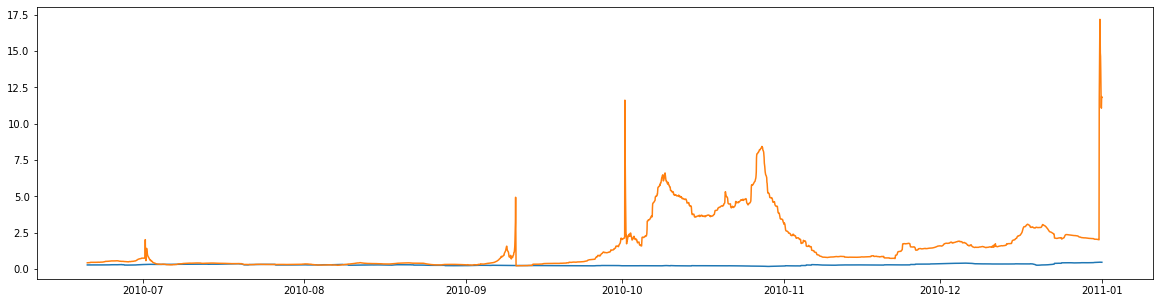

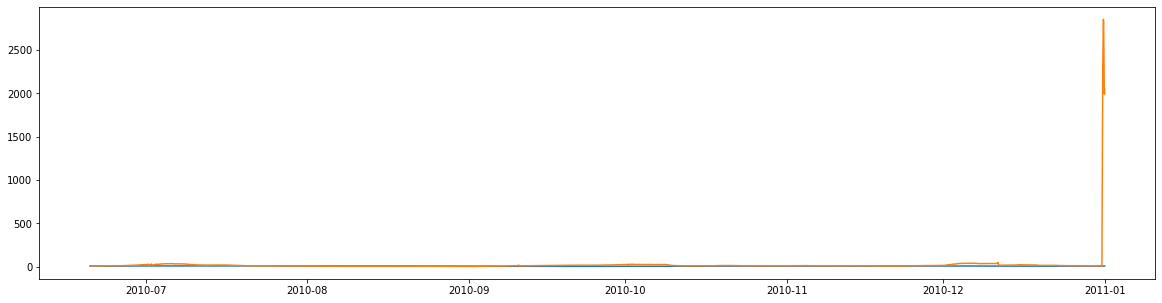

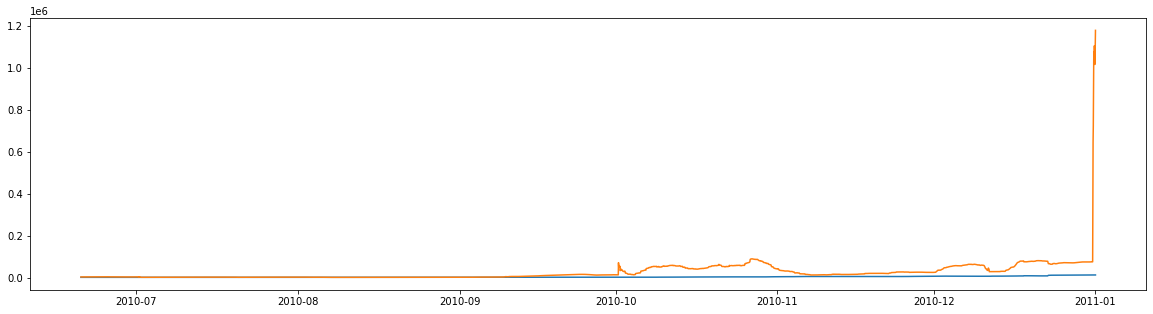

In [40]:
plt.rcParams["figure.figsize"] = 20,5
ridge_train, ridge_cv = cv_I_ridge(date_time ,df, features, targets, w_size = 2440, treshold = 0.7, alpha = 0, normalize = True)
for i in range(len(targets)):
    plt.plot(date_time[2439:], ridge_train[i])
    plt.plot(date_time[2439:], ridge_cv[i])
    plt.show()

In [41]:
def make_ridge_subm(train, test, features, targets, alpha = 0.1, min_period = 0, normalize = False):
    Y_hat = []
    costs = []
    for i in range(len(targets)):
        X_train = get_columns(train,features, min_period)
        Y_train = np.log(get_columns(train,targets[i], min_period))
        model = None
        if alpha != 0:
            model = Ridge(normalize = normalize, alpha = alpha, copy_X = True).fit(X_train, Y_train)
        else:
            model = LinReg(normalize = normalize, copy_X = True).fit(X_train, Y_train)
        #ridge = Ridge(alpha = alpha, copy_X = True).fit(get_columns(train,features, min_period), get_columns(train,targets[i], min_period))
        Y_hat.append(np.exp(model.predict(get_columns(test,features))))
        costs.append(MSE(np.exp(model.predict(X_train)), np.exp(Y_train)))
    return Y_hat, costs, model

In [42]:
Y_hat, costs, model = make_ridge_subm(df, test_df, features, targets, alpha = 0, min_period = 0, normalize = False)

[0.6991244633627681, 25.157355282171807, 20445.656424865057]


<BarContainer object of 12 artists>

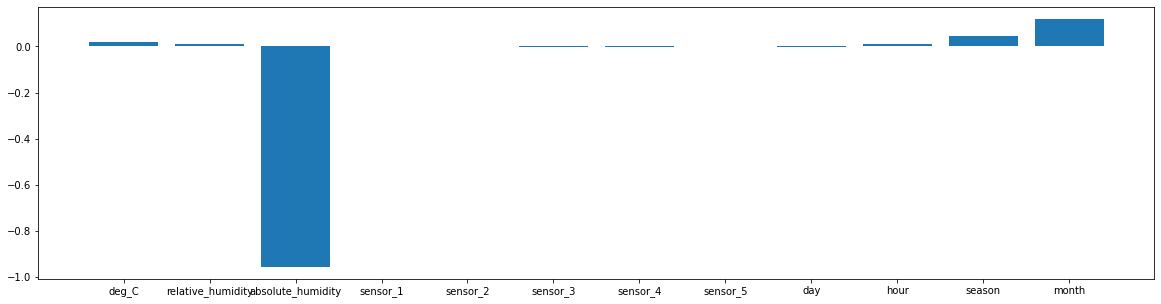

In [43]:
print(costs)
importance = model.coef_[0]
plt.bar([f for f in features], importance)

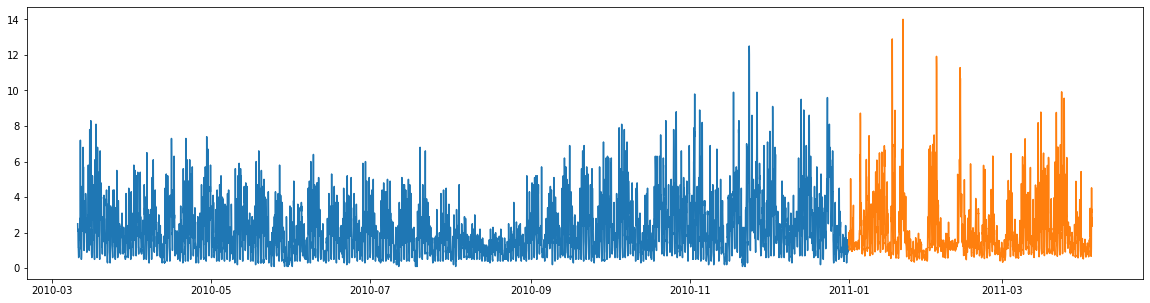

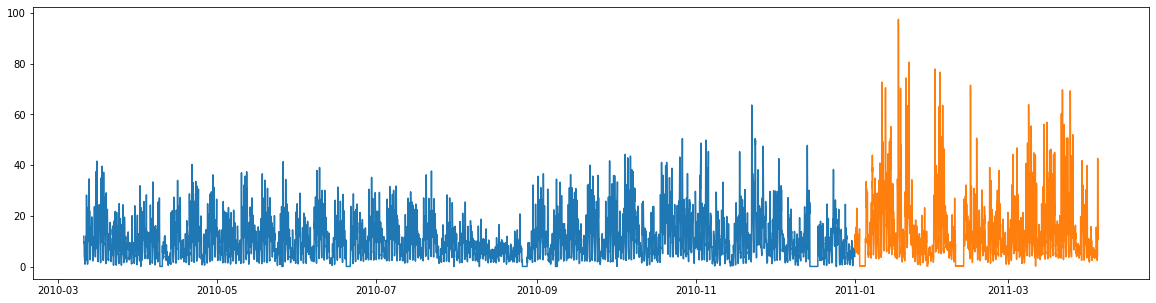

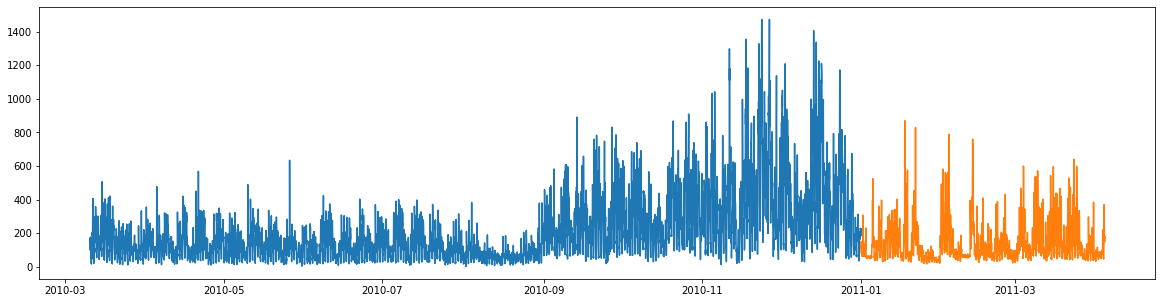

In [44]:
for i in range(len(targets)):
    plt.plot(date_time, df[targets[i]])
    plt.plot(test_date_time, Y_hat[i])
    plt.show()

In [45]:
ridge_df = pd.DataFrame(index = test_date_time)
for i in range(len(targets)):
    ridge_df[targets[i]] = Y_hat[i]

In [46]:
ridge_df.to_csv('submission.csv')

### Cross-Validation II
If X = [0 1 2 3 4 5 6 7 8] then\
train = [0 1 2], cv = [3, 4] ->\
train = [2 3 4], cv = [5, 6] ->\
train = [4, 5, 6], cv = [7, 8]\
end

In [47]:
def cv_II_ridge(date_time, df, features, targets, w_size, treshold, alpha = 0.1, normalize = False):
    train_loss, cv_loss = [], []
    time_labels = []
    for i in range(len(targets)):
        w_begin, w_cv, w_end = 0, int(treshold * w_size), w_size
        train_loss.append([])
        cv_loss.append([])
        time_labels.append([])
        while w_end <= len(df):
            time_labels[i].append(date_time[w_end])
            #print(w_begin, w_cv, w_end)
            X_train, Y_train = get_columns(df, features, w_begin, w_cv), np.log(get_columns(df, targets[i], w_begin, w_cv))
            model = None
            if alpha != 0:
                model = Ridge(alpha = alpha, copy_X = True).fit(X_train, Y_train)
            else:
                model = LinReg(copy_X = True).fit(X_train, Y_train)
            X_test, Y_test = get_columns(df, features, w_cv, w_end), np.log(get_columns(df, targets[i], w_cv, w_end))
            train_loss[i].append(MSE(np.exp(model.predict(X_train)),np.exp(Y_train)))
            cv_loss[i].append(MSE(np.exp(model.predict(X_test)), np.exp(Y_test)))
            delta = w_end - w_cv
            w_begin += delta
            w_cv += delta
            w_end += delta
    return train_loss, cv_loss, time_labels


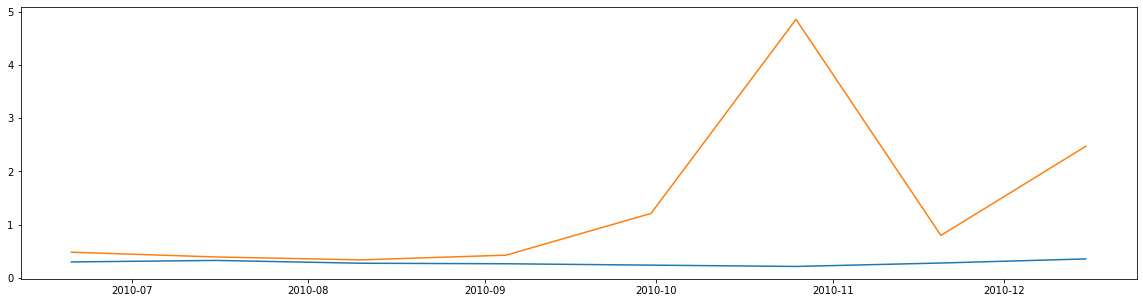

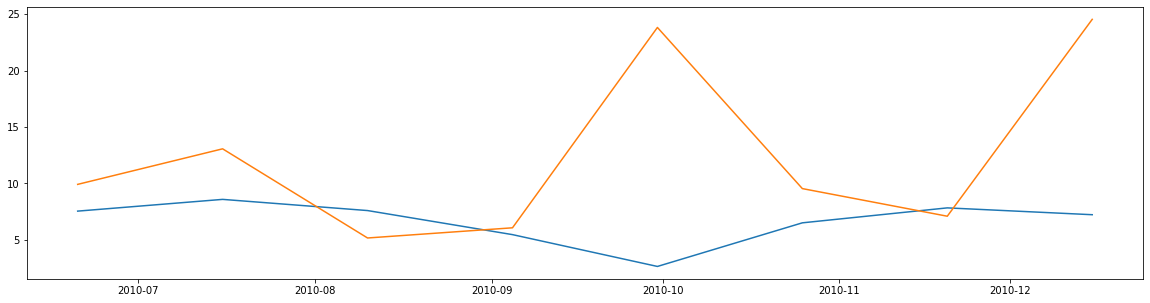

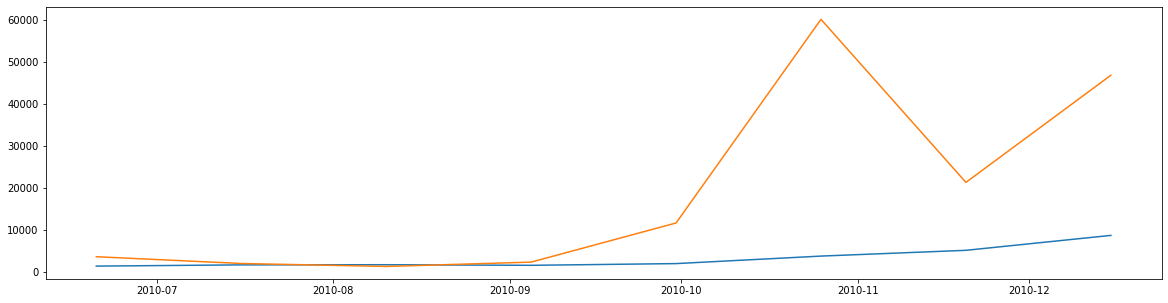

In [48]:
trl,cvl,T = cv_II_ridge(date_time = date_time ,df = df, features = features, targets = targets, w_size = 2440, treshold = 0.75, alpha = 1, normalize = False)
for i in range(len(targets)):
    plt.plot(T[i], trl[i])
    plt.plot(T[i], cvl[i])
    plt.show()

In [49]:
def make_window_sumb(test_date_time, train, test, features, targets, w_size, alpha = 0, normalize = False):
    Y_hat = []
    
    Z = pd.concat([train[-w_size + 1:], pd.concat([test, 
                   pd.DataFrame(0, index=np.arange(len(test_df)), columns=targets)], axis = 1)],ignore_index = True)
    
    
    for i in range(len(targets)):
        w_begin , w_sep, w_end = 0, w_size - 1, w_size
        while w_end <= len(Z):
            X_train = get_columns(Z, features, w_begin, w_sep)
            Y_train = np.log(get_columns(Z, targets[i], w_begin, w_sep))
            model = None
            if alpha != 0:
                model = Ridge(normalize = normalize, alpha = alpha, copy_X = True).fit(X_train, Y_train)
            else:
                model = LinReg(normalize = normalize, copy_X = True).fit(X_train, Y_train)
            X_test = get_columns(Z, features, w_sep, w_end)
            Z.loc[w_end - 1,targets[i]] =  np.exp(model.predict(X_test)[0])
            w_begin += 1
            w_sep += 1
            w_end += 1
    result = Z.loc[w_size - 1 :,  targets]
    result.index = test_date_time
    return result, model

In [50]:
Y_hat_, model = make_window_sumb(test_date_time, df, test_df, features, targets, w_size = 500, alpha = 0.1, normalize = True)

<BarContainer object of 12 artists>

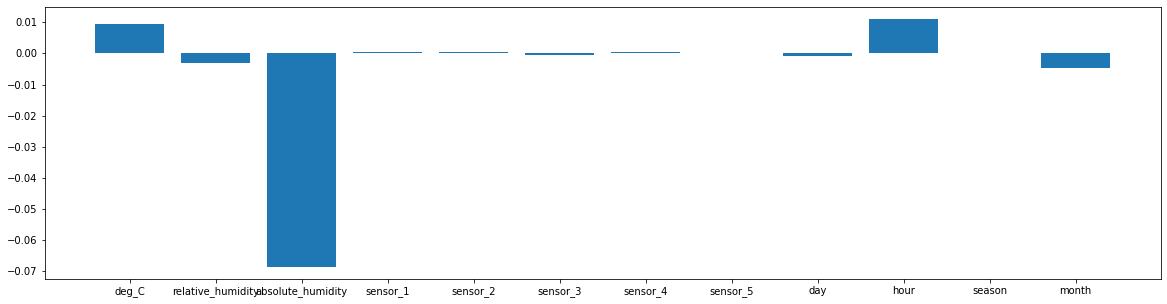

In [51]:
importance = model.coef_[0]
plt.bar([f for f in features], importance)

In [52]:
Y_hat_

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
date_time,,,
2011-01-01 00:00:00,1.469669,4.166332,199.999658
2011-01-01 01:00:00,2.170772,6.626271,279.661702
2011-01-01 02:00:00,1.611823,6.838336,217.735033
2011-01-01 03:00:00,1.709260,7.433540,229.347098
2011-01-01 04:00:00,1.372999,5.255818,184.254840
...,...,...,...
2011-04-04 10:00:00,3.272265,10.597185,461.181106
2011-04-04 11:00:00,2.633656,7.073140,382.762091
2011-04-04 12:00:00,2.730959,6.897074,402.204266


In [53]:
#Y_hat_.to_csv('submission.csv')

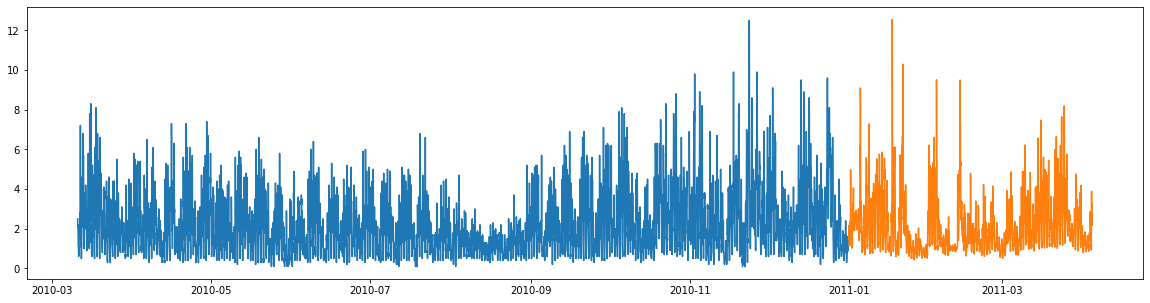

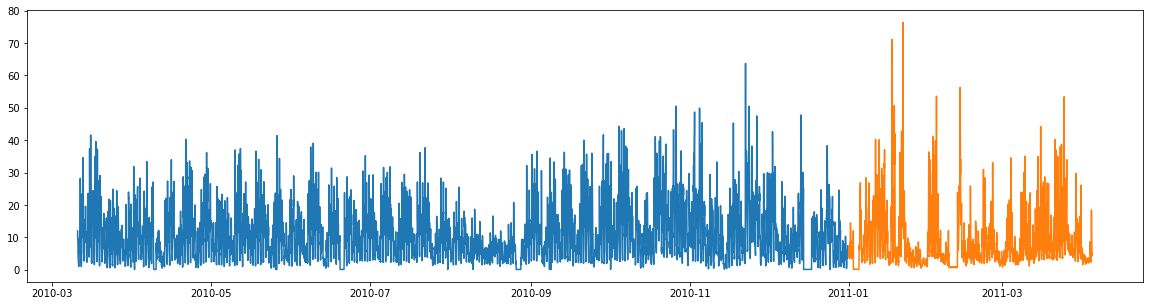

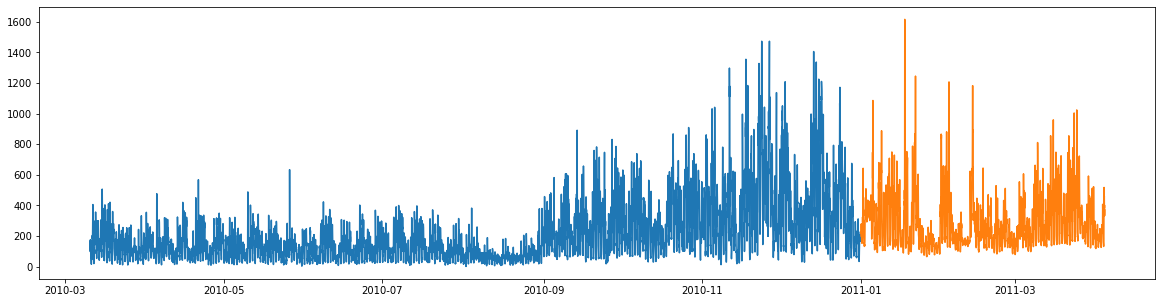

In [54]:
for i in range(len(targets)):
    plt.plot(date_time, df[targets[i]])
    plt.plot(test_date_time, Y_hat_[targets[i]])
    plt.show()

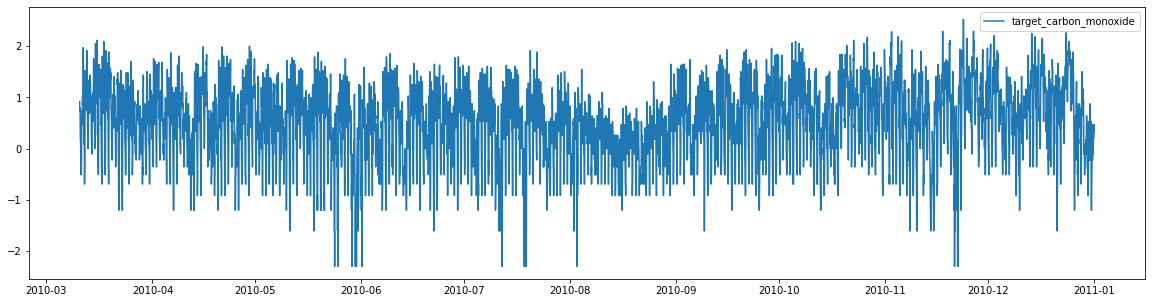

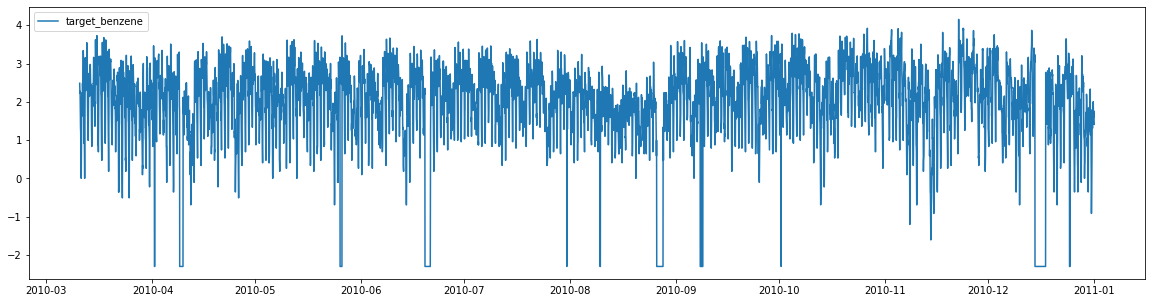

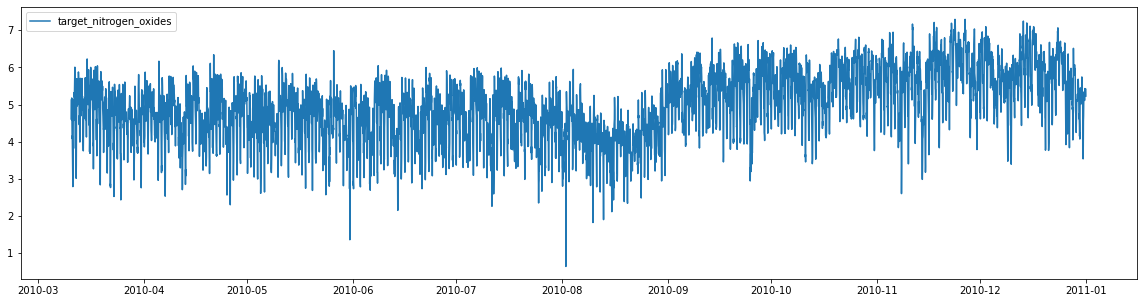

In [55]:
for t in targets:
    plt.plot(date_time,np.log(df[t]), label = t)
    plt.legend()
    plt.show()

features = features[:4] + features[-4:]
features

Y_hat, costs = make_ridge_subm(df, test_df, features, targets, alpha = 0, min_period = 0, normalize = False)
Y_hat_ = make_window_sumb(test_date_time, df, test_df, features, targets, w_size = 500, alpha = 0.1, normalize = True)